# Global ms diagnosis on main combination
- compute residual
- compute correlated and uncorrelated part of each term -> evaluate contribution in th H1 hypothesis (correlated part = physical signal)
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [16]:
DL =25*1e3 #meters
DT = 0.5*3600 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

In [17]:
def global_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsms.nb_coloc.sum('drifter_sat_year'))
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

# Datasets 

In [18]:
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsd.drifter_sat_year.values if 'argos' in l]
dsg = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=gps)).persist()
dsa = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=argos)).persist()

<xarray.DataArray 'nb_coloc' ()>
array(131411)
<xarray.DataArray 'nb_coloc' ()>
array(91830)


______________________
# Closure efficiancy : $\langle S^2 \rangle$ and $RSE = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [19]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100

In [20]:
print('Along-track')
print('S2 = ' + f"{dsg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsg, id_co)}")
print('AVISO')
print('S2 = ' + f"{dsg['sum_'+id_aviso].values}")
print(f"RSE = {RSE_id(dsg, id_aviso)}")


print('Along-track')
print('S2 = ' + f"{dsa['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsa, id_co)}")
print('AVISO')
print('S2 = ' + f"{dsa['sum_'+id_aviso].values}")
print(f"RSE = {RSE_id(dsa, id_aviso)}")

Along-track
S2 = 1.995774502868337e-10
RSE = 24.812564204978695
AVISO
S2 = 1.8086538898199847e-10
RSE = 26.698090306917948
Along-track
S2 = 1.9321344511121155e-10
RSE = 23.996150150072562
AVISO
S2 = 1.6305883907500505e-10
RSE = 23.85705395667425


Text(0, 0.5, '$\\langle S^2 \\rangle$ $[m^2/s^4]$')

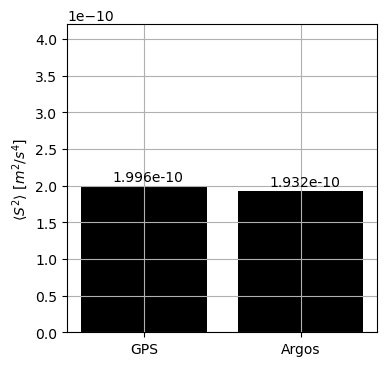

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, dsg['sum_'+id_co], color ='k',width = 0.4)
ax.bar(1, dsa['sum_'+id_co], color ='k',width = 0.4)
ax.text(0.4, dsg['sum_'+id_co]+dsg['sum_'+id_co]/30, str(np.format_float_scientific(dsg['sum_'+id_co].values,precision = 3)))
ax.text(0.9, dsa['sum_'+id_co]+dsa['sum_'+id_co]/30, str(np.format_float_scientific(dsa['sum_'+id_co].values,precision = 3)))

ax.grid()
ax.set_ylim(0,4.2e-10)
ticks = ('GPS', 'Argos')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$\langle S^2 \rangle$ $[m^2/s^4]$')

Text(0, 0.5, '$RSE$ [%]')

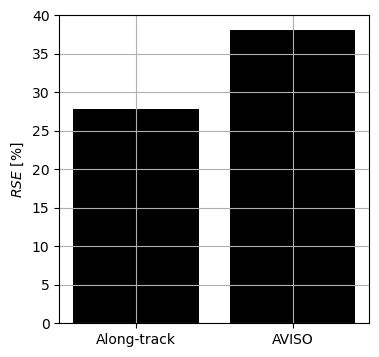

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, RSE_id(dsg, id_co), color ='k',width = 0.4)
ax.bar(1, RSE_id(dsa, id_co), color ='k',width = 0.4)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$RSE$ [%]')

______________________
# $x$ contribution : $Rc_{x_i} =\langle S_{-x_i}^2\rangle-\langle S^2 \rangle$  and $Rcn_{x_i} = \frac{\langle S_{-x_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [23]:
def plot_closure_bar(ds, id_, ax, title=1):
    """ Plot closure bars for a combination on the axis ax.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']

    # ACC X
    ax.bar(1.5, (np.sqrt(ds[acc]) + np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, (np.sqrt(ds[acc]) - np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, ds['exc_acc_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc], bottom = ds['exc_acc_' + id_],
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) + np.sqrt(ds[cor]))**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) - np.sqrt(ds[cor]))**2,
           color='w', width = 0.45, zorder=3, align = 'center', )
    ax.bar(2, ds['exc_coriolis_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor], bottom = ds['exc_coriolis_' + id_],
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) + np.sqrt(ds[ggrad]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) - np.sqrt(ds[ggrad]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, ds['exc_ggrad_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad], bottom = ds['exc_ggrad_' + id_],
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) + np.sqrt(ds[wd]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) - np.sqrt(ds[wd]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, ds['exc_wind_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd], bottom = ds['exc_wind_' + id_],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of ms^2
    ax.bar(1,ds[acc],
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor], bottom = ds[acc],
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad], bottom = ds[acc]+ds[cor],
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd], bottom = ds[acc]+ds[cor]+ds[ggrad],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]+ds[cor]+ds[ggrad]+ds[wd]
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['sum_'+id_]
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    #g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    #ggrad_tick='$\n $+'.join(g)
    #w = ds_all['rms_es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace('rms[',r'').replace(']','').split(' from')
    #wd_tick = '\n from'.join(w)
    #ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    #ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values}, coriolis:{ds[cor].values}, ggrad:{ds[ggrad].values}, wind:{ds[wd].values}')

In [24]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RC_x(ds, id_):
    if isinstance(id_, str):
        dic = ds['sum_'+id_].attrs
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_)
        df = pd.DataFrame({l:((ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s).values for l in lab}, index=pd.Index([id_], name='id_comb'))
    else :
        D =[]
        DN = []
        for id__ in id_ :
            dic = ds['sum_'+id__].attrs
            lab = ['acc', 'coriolis', 'ggrad', 'wind']
            s = compute_sum_ms(ds, id__)
            D.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])).values for l in lab}, index=pd.Index([id__], name='id_comb')))
            DN.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])/s).values for l in lab}, index=pd.Index([id__], name='id_comb')))
        df=pd.concat(D)
        dfn=pd.concat(DN)
    return df, dfn

In [25]:
rc, rcn = RC_x(dsa, [id_co, id_aviso])

In [26]:
rc

,acc,coriolis,ggrad,wind
id_comb,,,,
co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x,5.469878e-11,1.875077e-10,2.061009e-10,-2.954906e-11
aviso__25__adt__es_cstrio_z15__alti_x,2.099011e-11,1.287904e-10,2.363144e-10,-2.872981e-11


In [27]:
rcn

,acc,coriolis,ggrad,wind
id_comb,,,,
co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x,0.067933,0.232875,0.255967,-0.036698
aviso__25__adt__es_cstrio_z15__alti_x,0.030711,0.188433,0.345750,-0.042034


acc:9.261633325571003e-11, coriolis:3.7056390363860044e-10, ggrad:3.2832158771479906e-10, wind:1.368335677561058e-11
acc:9.261633325571003e-11, coriolis:3.7056390363860044e-10, ggrad:2.066491727782553e-10, wind:1.3653301022262965e-11


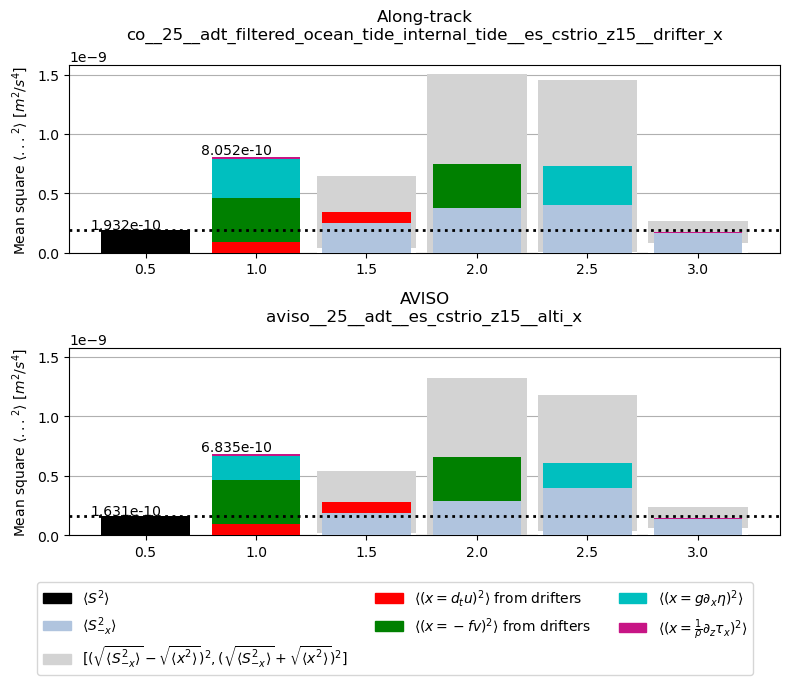

In [28]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(8,7))
plot_closure_bar(dsa, id_co ,axs[0], title = 'Along-track')
plot_closure_bar(dsa, id_aviso,axs[1], title = 'AVISO')


if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

________________________
# True/Error in $x$ 
$\langle \hat{x_i} \rangle +\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle+\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $
## Under H1

$\langle \hat{x_i} \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $

In [29]:
def true_err_x(ds, id_) :
    dso = xr.Dataset()
    dic = ds['sum_'+id_].attrs
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmsa = xr.concat([true_err_x(dsa, id_co), true_err_x(dsa, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
dsmsg = xr.concat([true_err_x(dsg, id_co), true_err_x(dsg, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [30]:
def plot_cor_uncor_part(ds, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    # ACC X
    ax.bar(1.5, ds['true_acc'],
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['acc']+5e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(1.5, ds['true_acc']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['true_coriolis'],
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['coriolis']+5e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(2, ds['true_coriolis']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # G GRADIENT SLA
    ax.bar(2.5, ds['true_ggrad'],
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['err_ggrad'], bottom = ds['true_ggrad'],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['ggrad']+5e-12, str(np.format_float_scientific(ds['ggrad'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_ggrad']/ds['ggrad']*100,2)
    ax.text(2.5, ds['true_ggrad']+5e-12, f'{rse.values}%', horizontalalignment='center')

        # WIND
    ax.bar(3, ds['true_wind'],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['err_wind'], bottom = ds['true_wind'],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['wind']+5e-12, str(np.format_float_scientific(ds['wind'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_wind']/ds['wind']*100,2)
    ax.text(3, ds['true_wind']+5e-12, f'{rse.values}%', horizontalalignment='center')

    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title+'\n')
    
    N=np.arange(1.5,3.5, 0.5) 
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

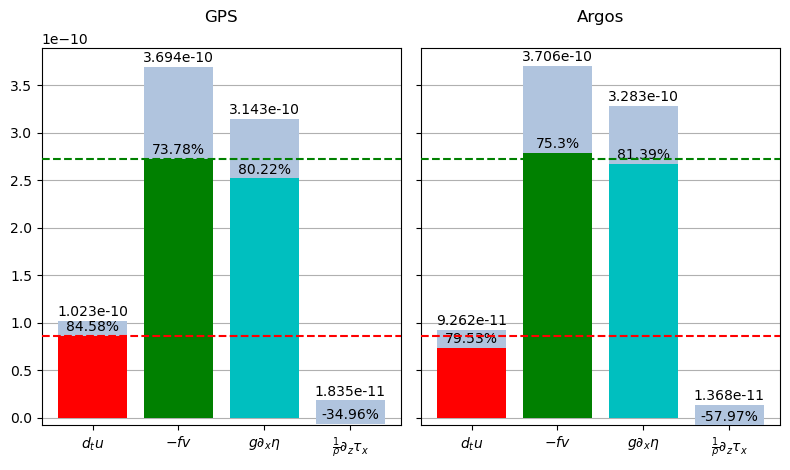

In [31]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(8,6))
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co), ax=axs[0], title ='GPS')
plot_cor_uncor_part(dsmsa.sel(id_comb=id_co), ax=axs[1], title ='Argos')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [19]:
dsmsa.true_acc - dsmsg.true_acc

<xarray.DataArray 'true_acc' (id_comb: 2)>
array([-9.25684648e-12, -6.07394169e-12])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...

In [20]:
# NOISE DOMINATES
a = 64/100
g = 25/100
print((dsmsg.acc/dsmsa.acc)/((1-a)/(1+g)))
#white noise
a = 48/100
g = 14/100
print((dsmsg.acc/dsmsa.acc)/( (1-a)/(1+g)))

<xarray.DataArray 'acc' (id_comb: 2)>
array([1.93311316, 1.93311316])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...
<xarray.DataArray 'acc' (id_comb: 2)>
array([1.22053791, 1.22053791])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...


In [21]:
# NOISE DOMINATES
a = 5/100
g = 1/100
print(dsmsg.coriolis/dsmsa.coriolis/((1-a)/(1+g)))
#white noise
a = 1.3/100
g = 0.04/100
print(dsmsg.coriolis/dsmsa.coriolis/((1-a)/(1+g)))

<xarray.DataArray 'coriolis' (id_comb: 2)>
array([0.96269925, 0.96269925])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...
<xarray.DataArray 'coriolis' (id_comb: 2)>
array([0.91780283, 0.91780283])
Coordinates:
  * id_comb  (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_tide__...


In [22]:
x=np.arange(0,100)
y = np.abs(dsmsa.acc.isel(id_comb=0).values*x/100 - dsmsg.acc.isel(id_comb=0).values*14/100 - dsmsa.acc.isel(id_comb=0).values + dsmsg.acc.isel(id_comb=0).values)

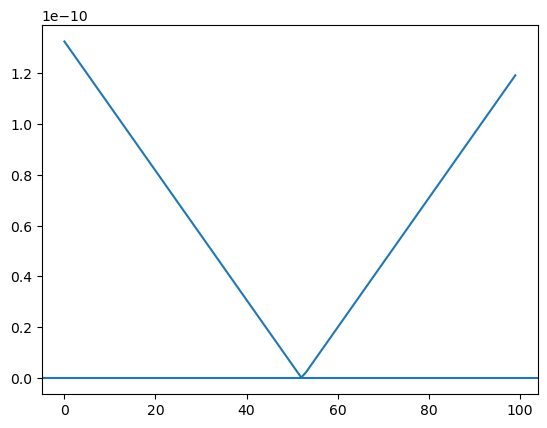

In [23]:
plt.plot(x, y)
plt.axhline(0)

## Validité erreurs non corrélées :

- erreurs coriolis/acceleration doivent être correlées -> possible de le voir ?

In [24]:
A = dsms['err_acc']+dsms['err_ggrad']+dsms['err_wind']+dsms['err_coriolis']

NameError: name 'dsms' is not defined

In [ ]:
A = dsms['err_acc']+dsms['err_ggrad']+dsms['err_wind']+dsms['err_coriolis']

In [ ]:
(A-dsms['S'])/dsms['S']